In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import pymc3 as pm
import pickle
import re

In [2]:
def geweke_diagnostic(fit, pattern, first=0.1, last=0.5, intervals=1):
    df = fit.set_index('draw') if isinstance(fit, pd.DataFrame) else fit.to_dataframe().set_index('draw')
    for param in (c for c in df.columns if re.search(pattern, c)):
        print('geweke statistics for', param)
        grouped = df.groupby('chain')
        for j, chain in enumerate(grouped.groups):
            print(f'chain {j}:\n', pm.geweke(grouped.get_group(chain)[param], first, last, intervals))

def hpd(fit, pattern, size=0.95):
    df = fit.set_index('draw') if isinstance(fit, pd.DataFrame) else fit.to_dataframe().set_index('draw')
    for param in (c for c in df.columns if re.search(pattern, c)):
        print(f'hpd for {param}:', pm.stats.hpd(df[param], size))

In [3]:
def pretty_trace(fit, pattern, labels=None, separate=True):
    df = fit.set_index('draw') if isinstance(fit, pd.DataFrame) else fit.to_dataframe().set_index('draw')
    for i, param in enumerate(c for c in df.columns if re.search(pattern, c)):
        grouped = df.groupby('chain')
        if separate:
            fig, ax = plt.subplots(nrows=len(grouped.groups))
            ax[0].set_title(labels[i] if labels else param)
            for j, chain in enumerate(grouped.groups):
                grouped.get_group(chain)[param].plot(ax=ax[j], linewidth=0.5)
        else:
            grouped[param].plot(alpha=0.6, legend=True, title=f'{param}: {labels[i]}' if labels else param,
                                linewidth=0.5)
        plt.show()

def pretty_hist(fit, pattern, labels=None, combine_chains=False, bins=50):
    df = fit.set_index('draw') if isinstance(fit, pd.DataFrame) else fit.to_dataframe().set_index('draw')
    for i, param in enumerate(c for c in df.columns if re.search(pattern, c)):
        if combine_chains:
            toplot= df[param]
        else:
            toplot = df.groupby('chain')[param]
        toplot.plot.hist(alpha=0.7, bins=bins,
                         legend=not combine_chains, title=f'{param}: {labels[i]}' if labels else param,
                         color='#F4951C' if combine_chains else None)
        plt.show()


In [4]:
def load_model(model_file, fit_file):
    with open(model_file, 'rb') as fh:
        model = pickle.load(fh)
    with open(fit_file, 'rb') as fh:
        fit = pickle.load(fh)
    return model, fit

reg_model, reg_fit = load_model('model.pkl', 'fit.pkl')
logit_model, logit_fit = load_model('logit_model.pkl', 'logit_fit.pkl')

In [5]:
reg_features = ['availability', 'explicit', 'track_number', 'days_since_release', 'num_artists', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature_4']
logit_features = reg_features + ['popularity']
# See https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/ for explanations

In [6]:
# linear regression diagnostics
geweke_diagnostic(reg_fit, '(?:sigma|theta|nu|alpha)')

geweke statistics for alpha


/home/mckay/anaconda3/lib/python3.7/site-packages/arviz/stats/stats_utils.py:484: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /home/mckay/anaconda3/lib/python3.7/site-packages/arviz/stats/stats_utils.py (486)

File "../../../../anaconda3/lib/python3.7/site-packages/arviz/stats/stats_utils.py", line 486:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/home/mckay/anaconda3/lib/python3.7/site-packages/arviz/stats/stats_utils.py:484: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../../../../anaconda3/lib/python3.7/site-packages/arviz/stats/stats_utils.py", line 487:
def stats_variance_1d(data, ddof=0):
    <sour

chain 0:
 [[ 0.         -0.00909865]]
chain 1:
 [[ 0.         -0.02436751]]
geweke statistics for theta[1]
chain 0:
 [[ 0.         -0.02683758]]
chain 1:
 [[ 0.         -0.01290195]]
geweke statistics for theta[2]
chain 0:
 [[ 0.         -0.01382751]]
chain 1:
 [[0.         0.01777462]]
geweke statistics for theta[3]
chain 0:
 [[ 0.         -0.00605273]]
chain 1:
 [[0.         0.01727046]]
geweke statistics for theta[4]
chain 0:
 [[ 0.         -0.00164286]]
chain 1:
 [[ 0.        -0.0160547]]
geweke statistics for theta[5]
chain 0:
 [[0.         0.01493373]]
chain 1:
 [[ 0.         -0.03313244]]
geweke statistics for theta[6]
chain 0:
 [[0.         0.02445718]]
chain 1:
 [[ 0.         -0.00125694]]
geweke statistics for theta[7]
chain 0:
 [[0.         0.00164192]]
chain 1:
 [[ 0.         -0.03467812]]
geweke statistics for theta[8]
chain 0:
 [[0.         0.00535135]]
chain 1:
 [[0.         0.00979781]]
geweke statistics for theta[9]
chain 0:
 [[ 0.         -0.00910862]]
chain 1:
 [[0. 

In [7]:
# Summary
print(reg_fit.stansummary())

Inference for Stan model: anon_model_0dc93036e7c029618cf7e5b0ef0f8f66.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

                mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha          26.04  3.5e-4    0.07   25.89   25.99   26.04   26.09   26.18  43297    1.0
theta[1]        9.62  3.6e-4    0.07    9.48    9.57    9.62    9.67    9.76  39821    1.0
theta[2]        5.57  3.2e-4    0.07    5.43    5.53    5.57    5.62    5.71  49884    1.0
theta[3]       -4.95  3.5e-4    0.07   -5.09    -5.0   -4.95    -4.9   -4.81  43318    1.0
theta[4]        -3.1  3.3e-4    0.07   -3.24   -3.15    -3.1   -3.06   -2.97  45146    1.0
theta[5]       -0.47  3.4e-4    0.07   -0.61   -0.51   -0.47   -0.42   -0.33  43411    1.0
theta[6]         2.0  3.5e-4    0.07    1.86    1.96     2.0    2.05    2.14  40368    1.0
theta[7]        2.84  3.5e-4    0.07     2.7    2.79    2.84    2.89    2.98  422

In [8]:
# hpd intervals for nonsymmetric distributions
hpd(reg_fit, r'(?:nu|sigma)')

hpd for sigma_raw: [16.28282003 16.48593943]
hpd for nu: [ 73.32145004 160.75063322]
hpd for sigma: [16.12098317 16.34778131]


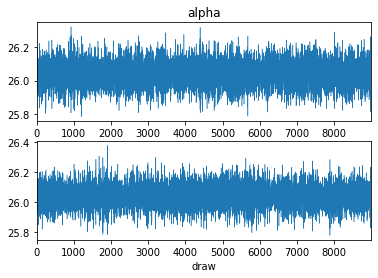

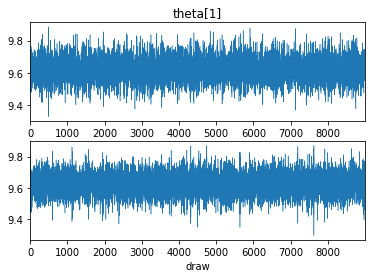

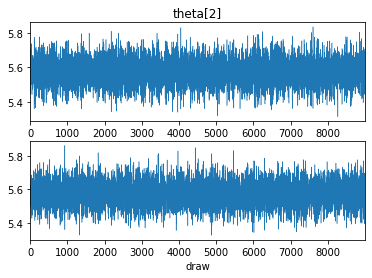

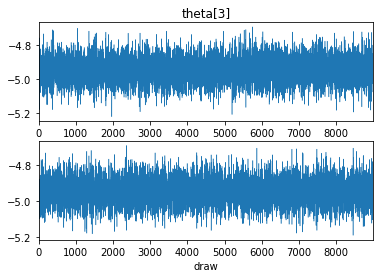

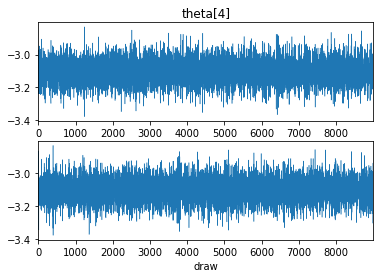

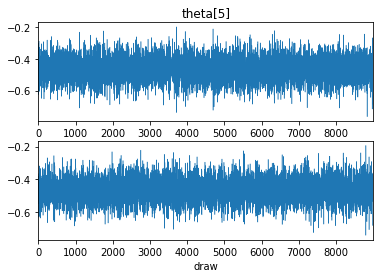

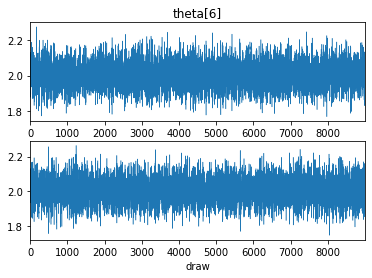

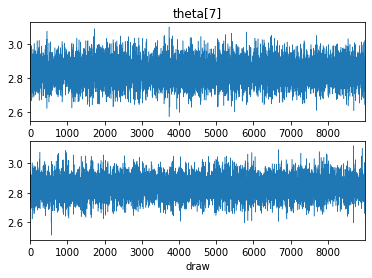

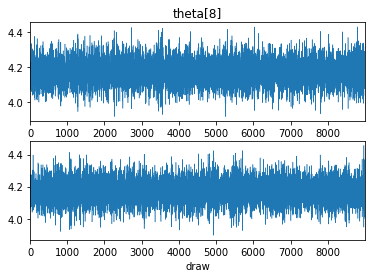

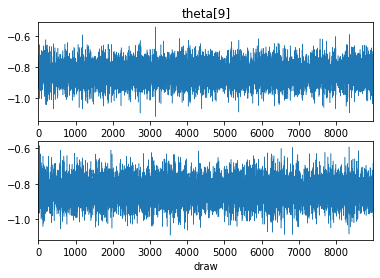

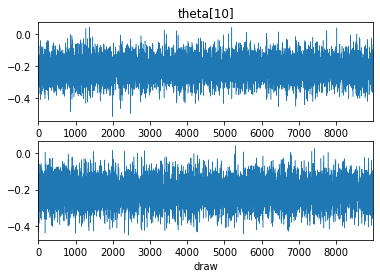

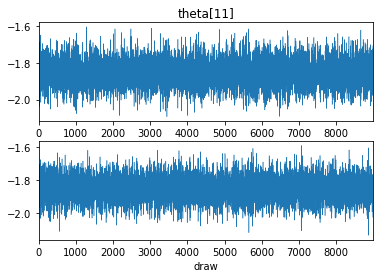

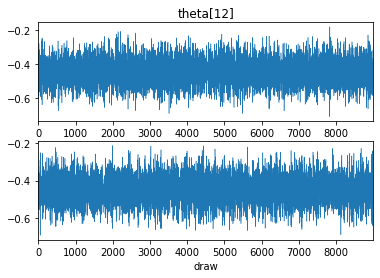

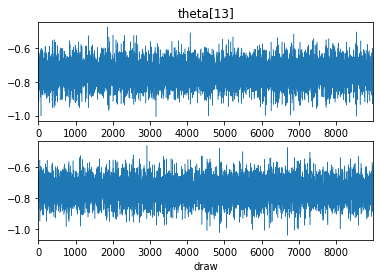

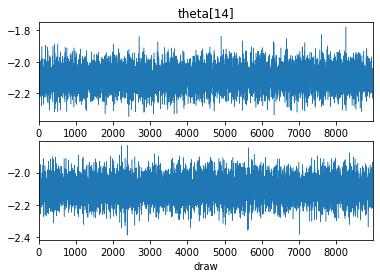

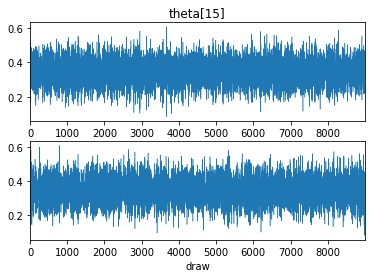

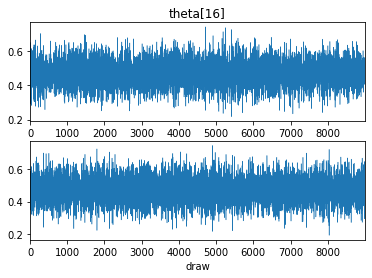

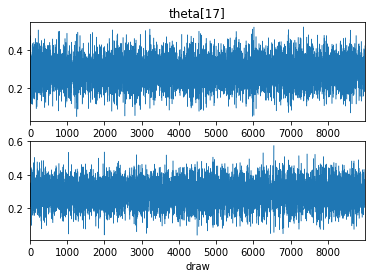

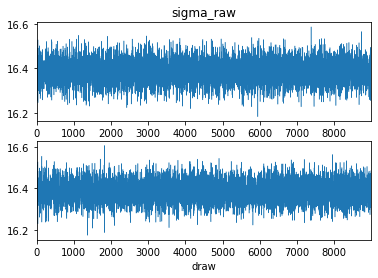

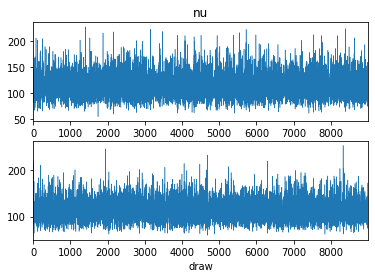

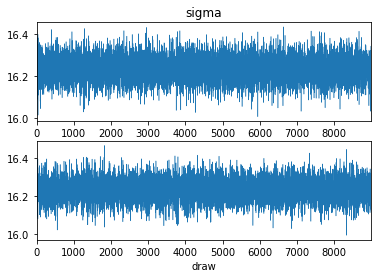

In [9]:
# Traceplots for linear regression
pretty_trace(reg_fit, r'(?:sigma|theta|nu|alpha)')

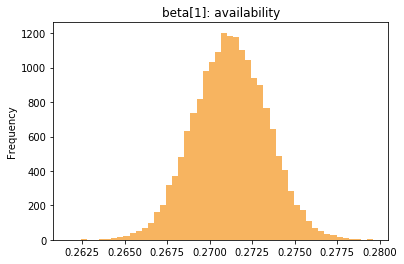

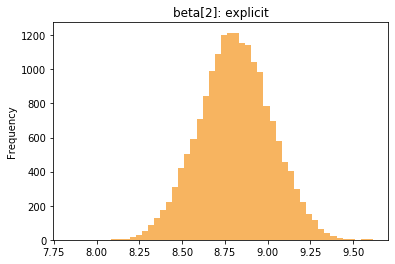

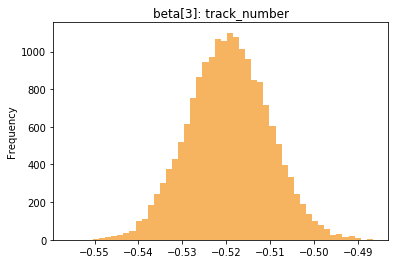

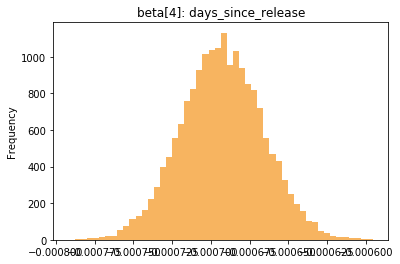

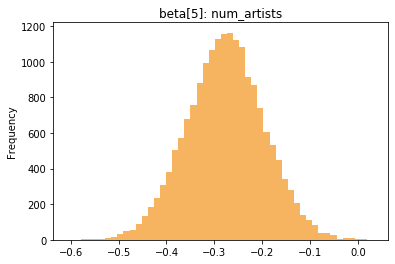

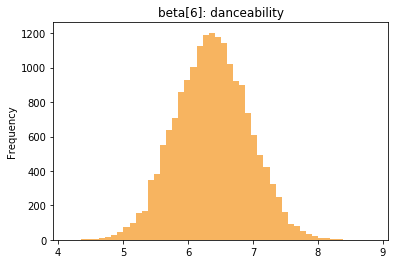

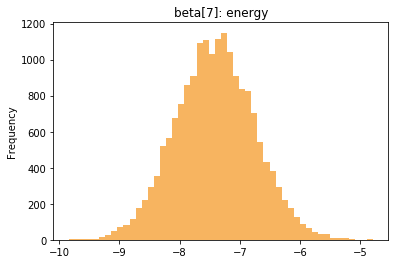

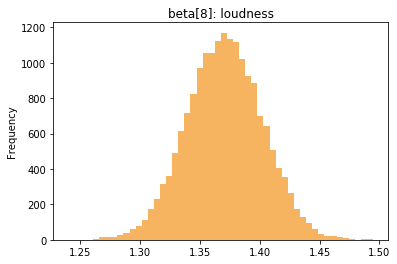

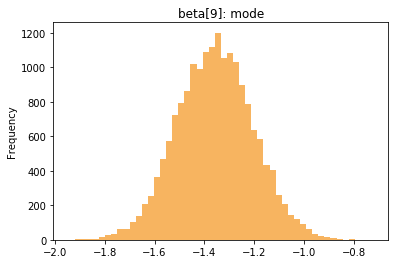

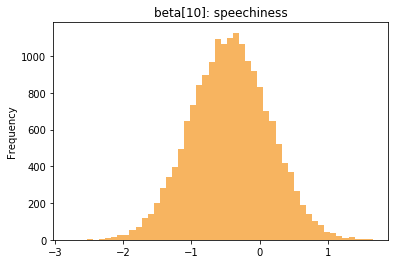

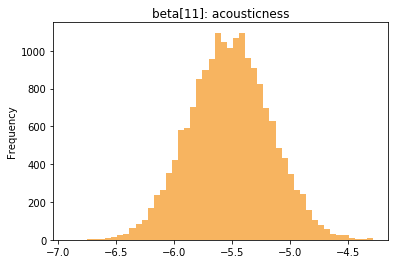

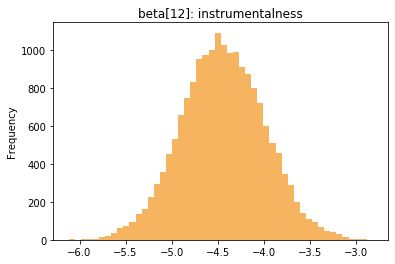

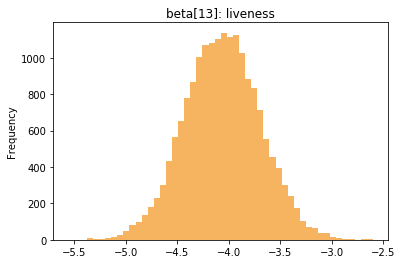

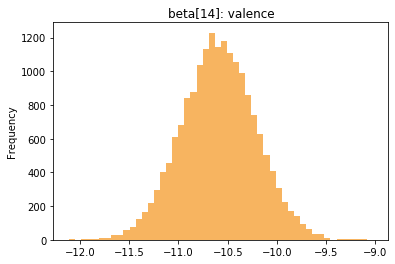

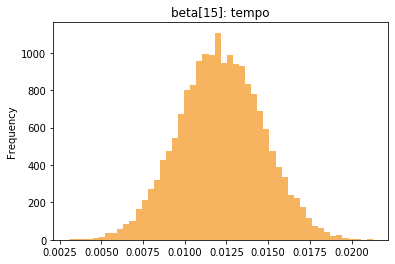

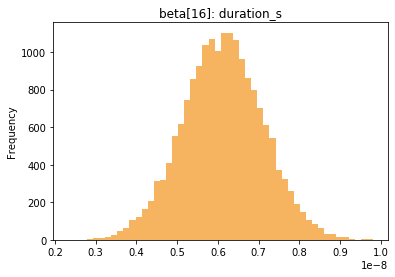

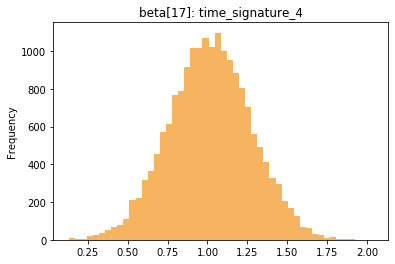

In [10]:
# Histograms for linear regression
pretty_hist(reg_fit, r'beta\[\d+\]', labels=reg_features, combine_chains=True)

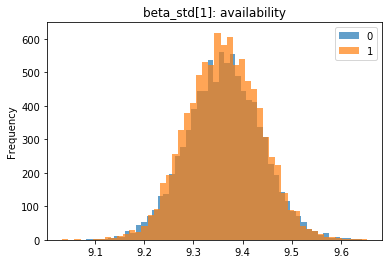

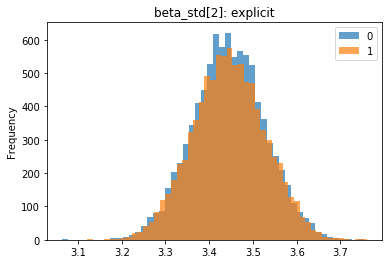

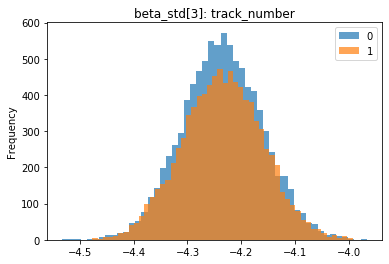

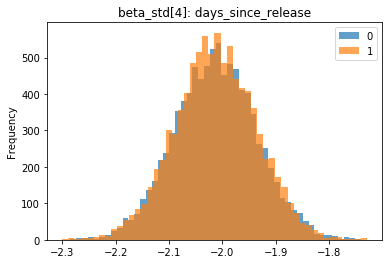

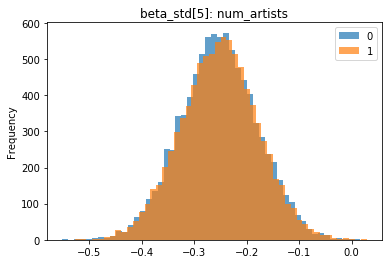

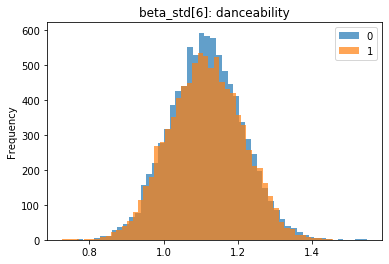

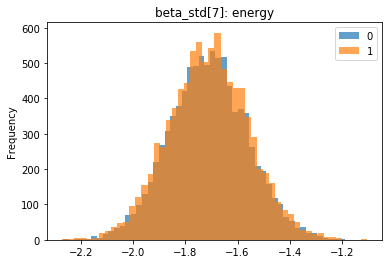

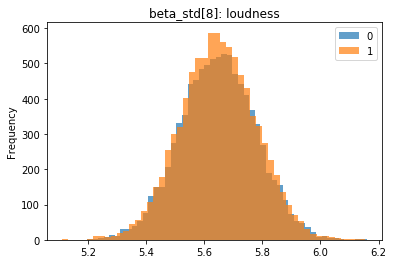

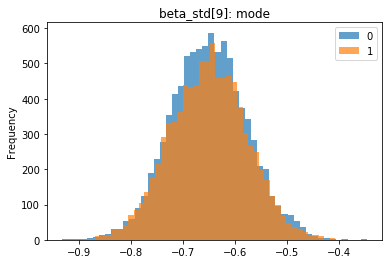

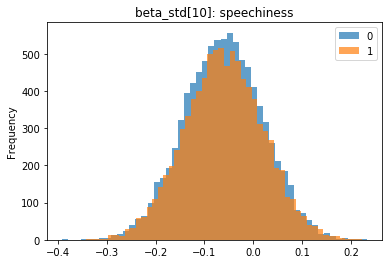

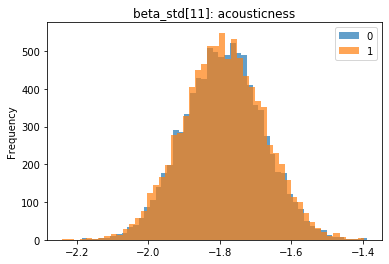

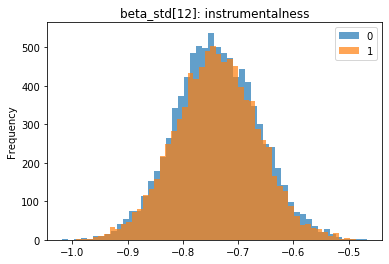

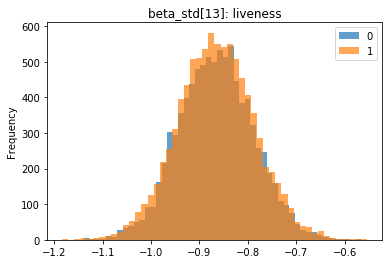

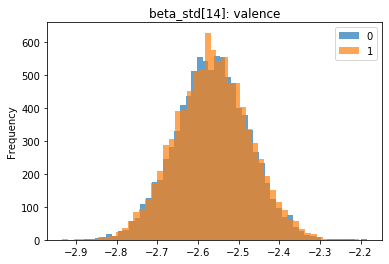

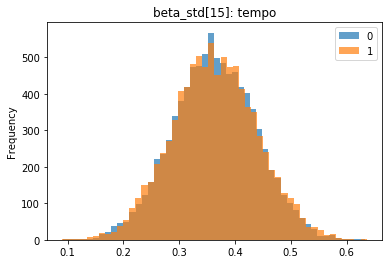

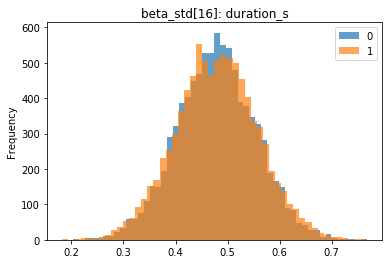

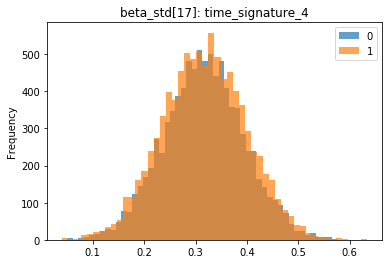

In [11]:
# Normalized histograms for linear regression
pretty_hist(reg_fit, r'beta_std\[\d+\]', labels=reg_features)

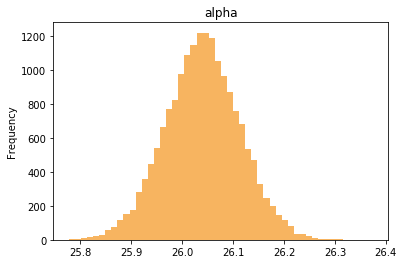

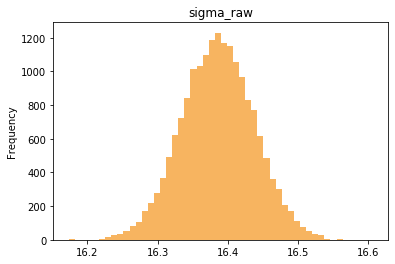

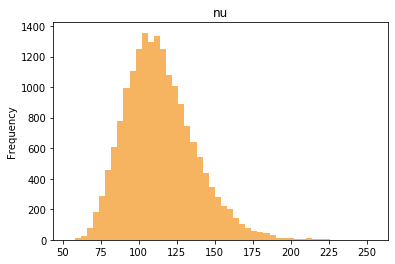

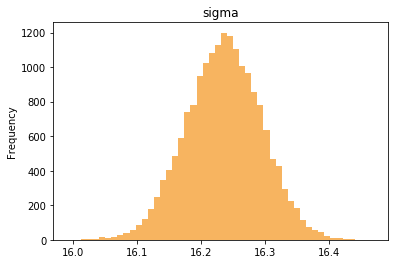

In [12]:
# Other histograms for linear regression
pretty_hist(reg_fit, r'(?:alpha|sigma|nu)', combine_chains=True)

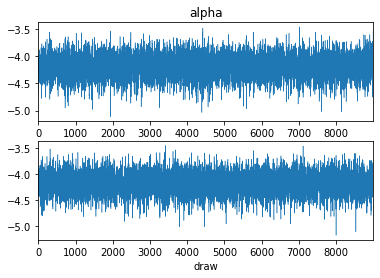

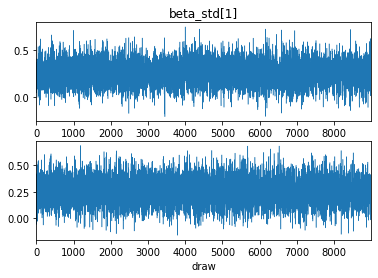

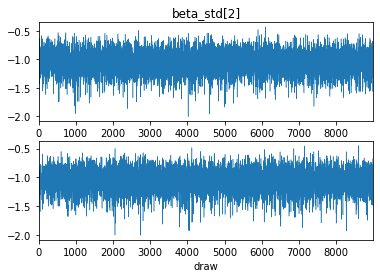

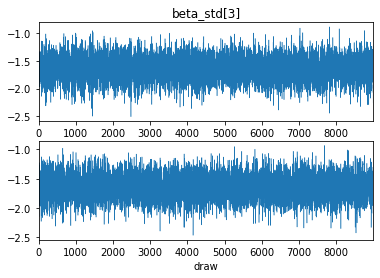

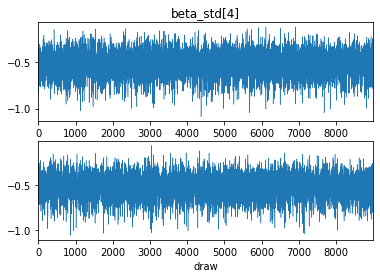

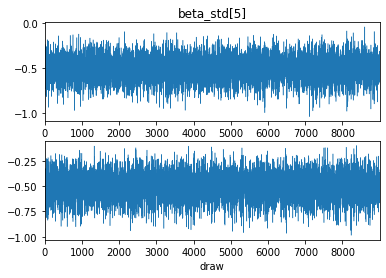

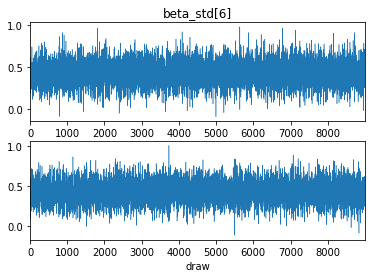

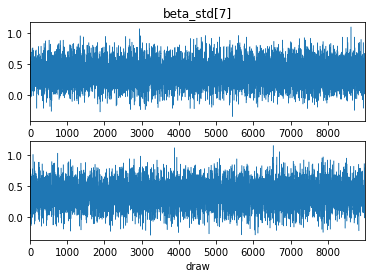

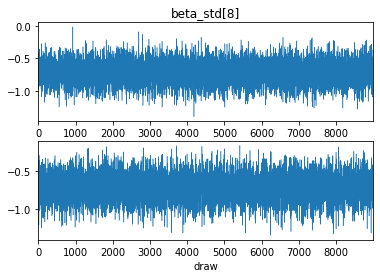

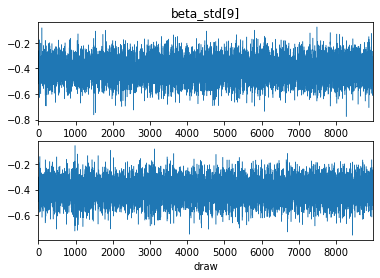

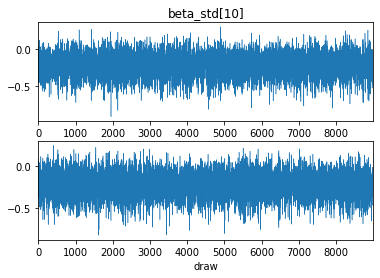

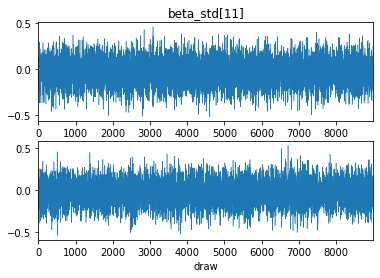

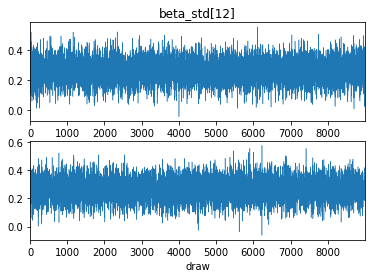

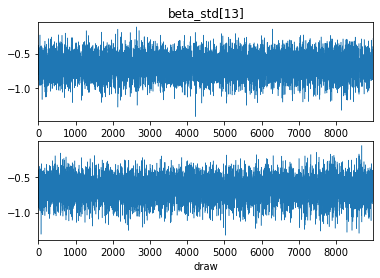

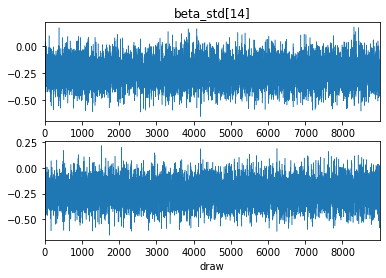

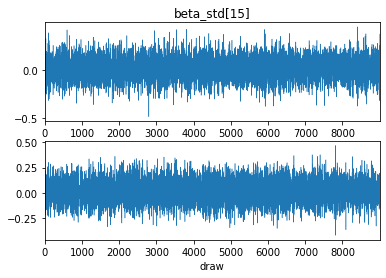

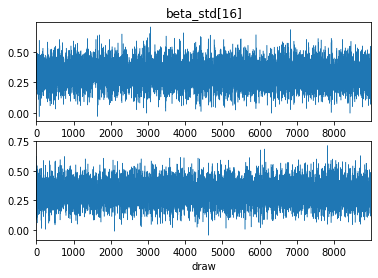

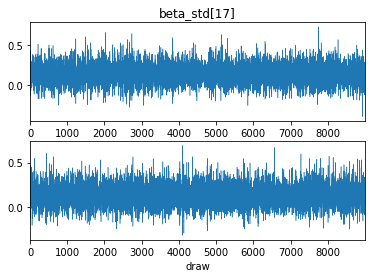

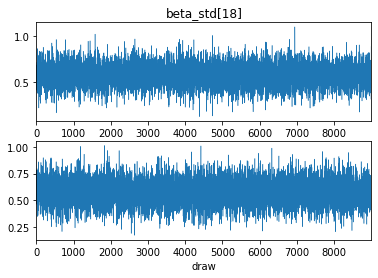

In [13]:
pretty_trace(logit_fit, r'(?:alpha|beta_std\[\d+\])')

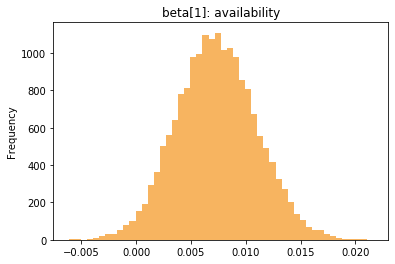

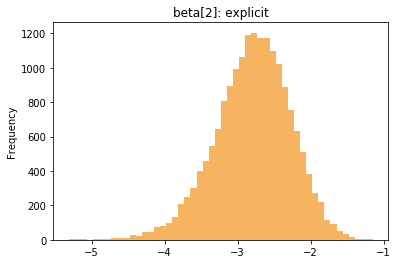

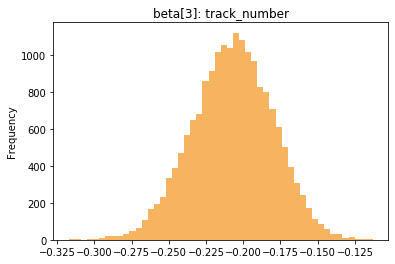

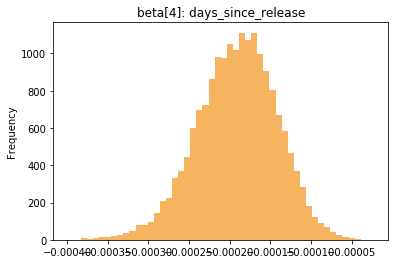

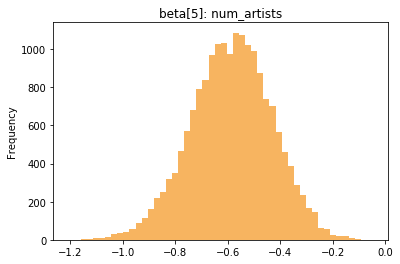

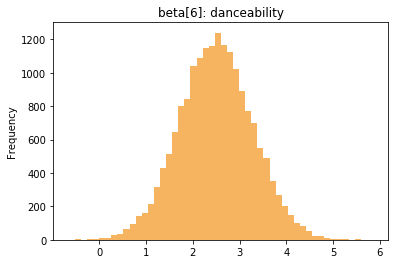

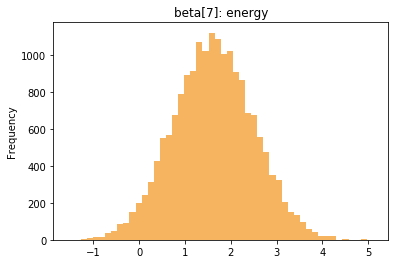

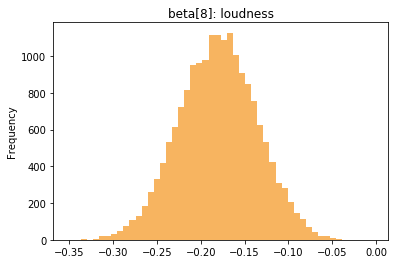

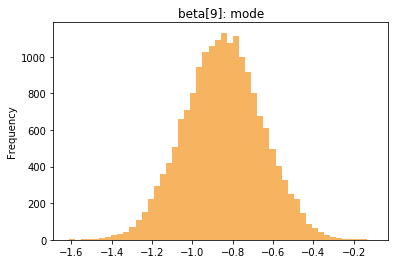

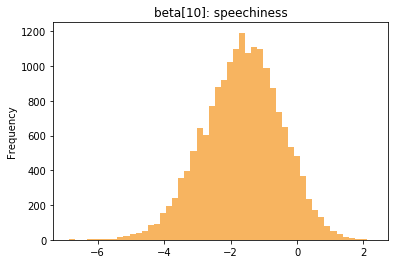

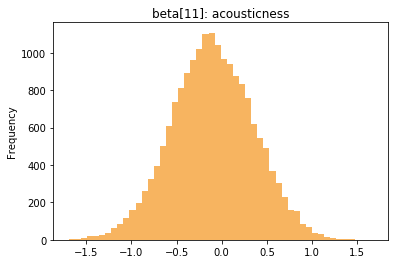

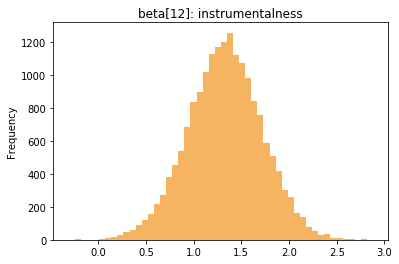

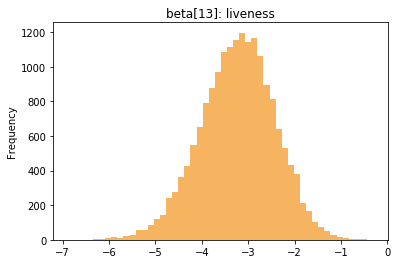

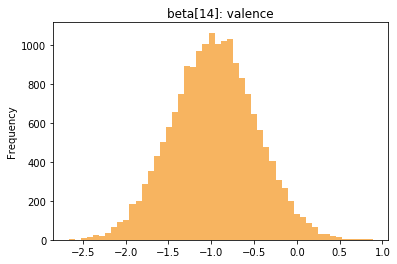

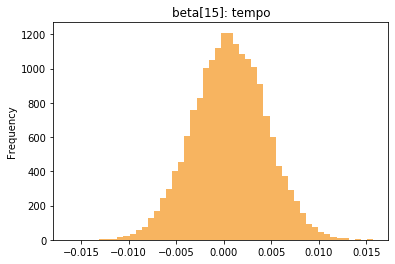

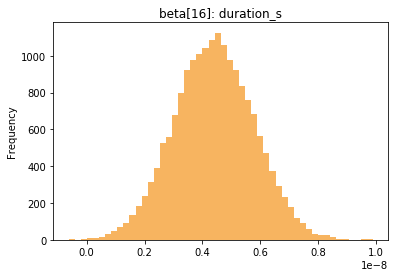

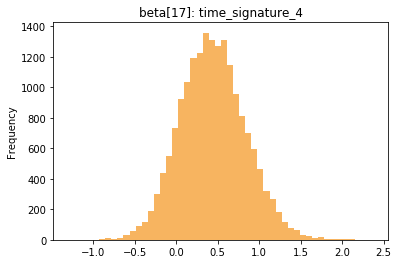

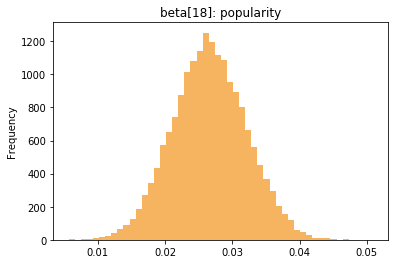

In [14]:
# Histograms for logistic regression
pretty_hist(logit_fit, r'beta\[\d+\]', labels=logit_features, combine_chains=True)

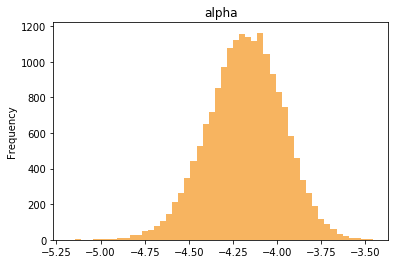

In [15]:
pretty_hist(logit_fit, r'alpha', combine_chains=True)

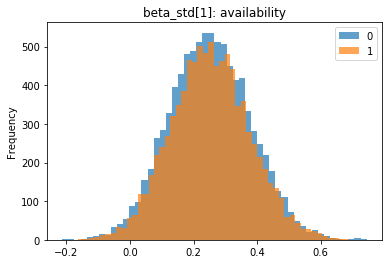

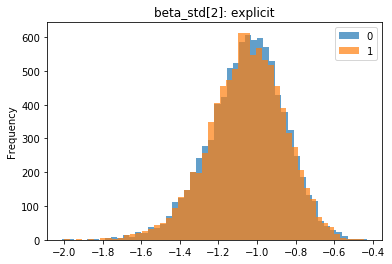

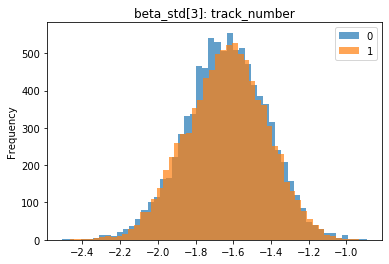

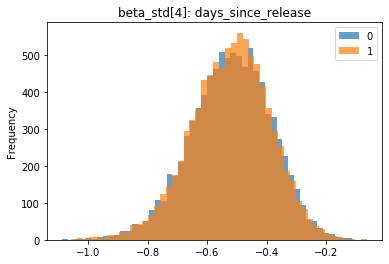

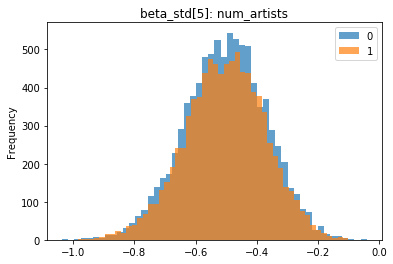

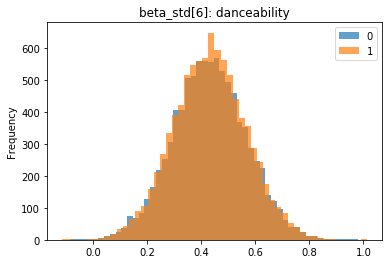

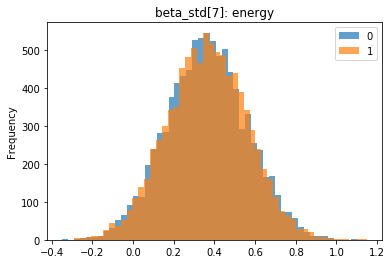

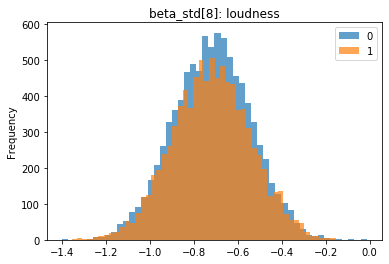

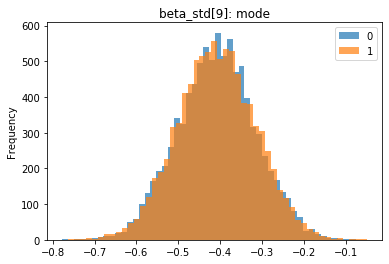

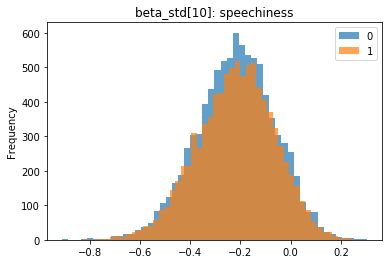

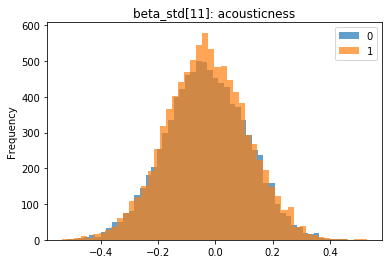

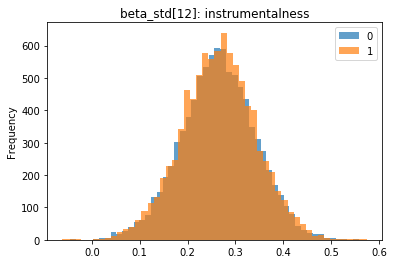

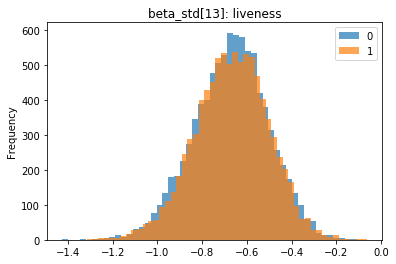

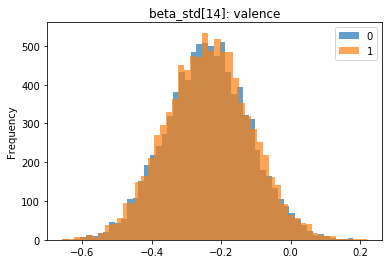

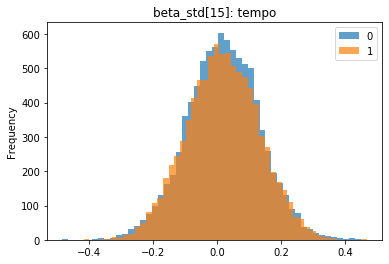

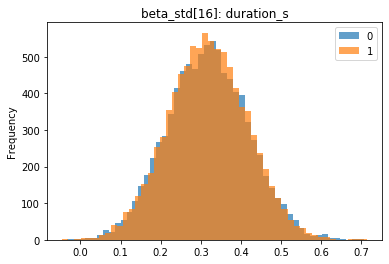

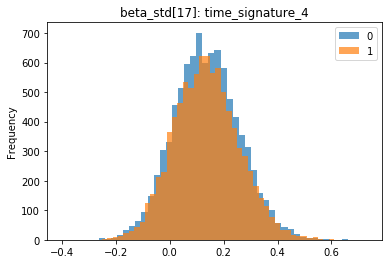

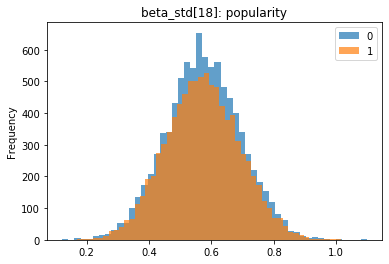

In [16]:
# Normalized histograms for logistic regression
pretty_hist(logit_fit, r'beta_std\[\d+\]', labels=logit_features)

In [17]:
geweke_diagnostic(logit_fit, r'alpha|beta_std')

geweke statistics for alpha
chain 0:
 [[0.         0.01578207]]
chain 1:
 [[0.         0.01437635]]
geweke statistics for beta_std[1]
chain 0:
 [[ 0.         -0.00412536]]
chain 1:
 [[ 0.         -0.02407814]]
geweke statistics for beta_std[2]
chain 0:
 [[0.         0.02103338]]
chain 1:
 [[0.         0.01077571]]
geweke statistics for beta_std[3]
chain 0:
 [[ 0.         -0.01251943]]
chain 1:
 [[0.        0.0019469]]
geweke statistics for beta_std[4]
chain 0:
 [[ 0.         -0.01446823]]
chain 1:
 [[0.         0.00391257]]
geweke statistics for beta_std[5]
chain 0:
 [[0.         0.01819172]]
chain 1:
 [[0.        0.0124459]]
geweke statistics for beta_std[6]
chain 0:
 [[ 0.         -0.04495308]]
chain 1:
 [[0.         0.00518655]]
geweke statistics for beta_std[7]
chain 0:
 [[0.         0.00450303]]
chain 1:
 [[0.        0.0083935]]
geweke statistics for beta_std[8]
chain 0:
 [[0.         0.00539873]]
chain 1:
 [[0.         0.00279842]]
geweke statistics for beta_std[9]
chain 0:
 [[0.

In [18]:
print(logit_fit.stansummary())

Inference for Stan model: anon_model_04131dd70d4d457c0ddaefb4b3c93810.
2 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=18000.

                mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha          -4.18  1.5e-3   0.21   -4.61   -4.32   -4.18   -4.04   -3.79  19546    1.0
beta_std[1]     0.25  7.3e-4   0.13    0.01    0.17    0.25    0.34     0.5  29863    1.0
beta_std[2]    -1.06  1.2e-3    0.2   -1.47   -1.18   -1.05   -0.92    -0.7  27318    1.0
beta_std[3]    -1.64  1.3e-3   0.21   -2.06   -1.78   -1.63   -1.49   -1.24  25660    1.0
beta_std[4]    -0.52  7.9e-4   0.13    -0.8   -0.61   -0.52   -0.43   -0.28  28408    1.0
beta_std[5]     -0.5  7.9e-4   0.13   -0.77   -0.59    -0.5   -0.41   -0.25  27972    1.0
beta_std[6]     0.43  8.8e-4   0.14    0.16    0.34    0.43    0.52     0.7  23662    1.0
beta_std[7]     0.36  1.4e-3    0.2   -0.02    0.23    0.36     0.5    0.75  18656    1.0